# fPCA applied to EEG data around braking event  

This is the first attempt into constructing a Karhunen Loeve decomposition for the EEG data coming from Emergency Braking experiment. 

The following is a temporal model in that considers all the electrodes as independet samples.

In the notebook **fPCA applied to spatiotemporal reconstruction of EEG data around braking event** a descomption that takes into account the **spatio**-temporal structure is study.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import pandas as pd 

In [45]:
# DO not run
import os
path_to_data = os.path.normpath(os.path.join('/Users/obando_c/Documents/Neuro/EmergencyBraking/data/post_processed/Only_events'))
files = sorted([elt for elt in os.listdir(path_to_data) if elt[-4:] == '.npy'],
                   key=(lambda x: int(x.split('_')[2])))

df_eeg_events = pd.DataFrame([])
eeg_events_index = []
for num, file in enumerate(files): # create a pandas df with 
    df_interval = pd.DataFrame(data = np.load(os.path.join(path_to_data,file)))
    outliers = np.unique(np.where(np.asarray(df_interval)>2000)[0])
    if len(outliers) == 0:
        df_eeg_events = df_eeg_events.append(df_interval)
        eeg_events_index = np.append(eeg_events_index, int(num))
df_eeg_events.to_csv(r'df_eeg_only_events.csv', index = False)
print(df_eeg_events.shape)

(13216, 320)


## <font color='blue'> Import learning data </font>

In [2]:
test_id = "VPja.mat" # Not used here
df_eeg_event_file = 'df_eeg_only_events.csv' # Corresponds to VPja
#Lecture
df_eeg_events = pd.read_csv( df_eeg_event_file )
n_channels = 59
split   = df_eeg_events.shape[1] 
nSample = df_eeg_events.shape[0]
#Traitement  
NPeeg = np.asarray(df_eeg_events)
NPeegC = NPeeg-NPeeg.mean(axis=1).reshape(-1,1) # Pour qu'ils soient comparables
mu_t    = NPeegC.mean(axis=0) # Pour avoir des processus centrés

In [3]:
NPeegC.shape

(13216, 320)

##  <font color='blue'>FPCA </font>

In [4]:
# OpenTurns:
import openturns as ot
dim_ch = 1
step_ms = 1 # 5 for 5ms as in data 
time_grid      = ot.RegularGrid(0, step_ms, split) # RegularGrid(start, step, n)
process_sample = ot.ProcessSample(time_grid, nSample, dim_ch) 
field          = ot.Field(time_grid, dim_ch)                     #le 1 correspond a la dimension du champ en sortie
for k in range(process_sample.getSize()):
    field.setValues(NPeegC[k:k+dim_ch,:].T - mu_t.reshape(-1,1))
    process_sample[k] = field

### <font color='green'> Etape 1: KarhunenLoeve </font>

In [5]:
s = 0.0 # 
algo = ot.KarhunenLoeveSVDAlgorithm(process_sample, s) #0.0 (=s) correspond au threshold sur les valeurs propres
algo.run()

fPCA     = algo.getResult() # The structure containing all the results of the Fredholm problem
Xi       = fPCA.project(process_sample) # Project a function or a field on the eigenmodes basis.
XiLambda = Xi * ot.Point([np.sqrt(x) for x in fPCA.getEigenValues()])

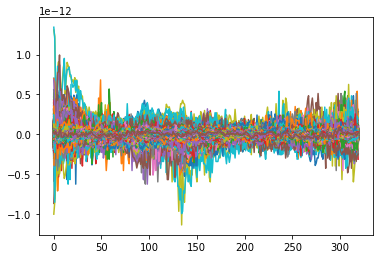

In [9]:
T     = np.array([t for t in time_grid.getValues()]).reshape(-1,1)
V_app = ot.DualLinearCombinationFunction(fPCA.getModes(), np.array(XiLambda).T) # TO reconstruct the signal

for k in range(process_sample.getSize()):
    res = process_sample[k].getValues() - V_app .getMarginal(k)(T)
    plt.plot (res)

### <font color='green'> Etape 2: PCA - erreur de troncature</font>

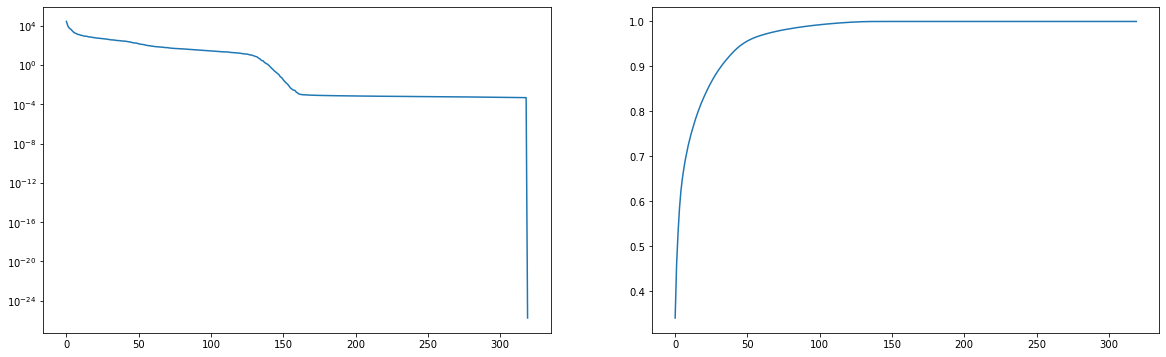

In [6]:
vp      = fPCA.getEigenValues() #  getEigenValues method enables to obtain the K first eigenvalues of the Karhunen Loeve decomposition
pVar    = np.cumsum(vp) / np.sum(vp)
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].semilogy(vp)
ax[1].plot (pVar)

## <font color='blue'> La détection d'anomalies </font>

In [7]:
#Avec 2 modes
nModes = 2
X      = Xi.getMarginal ([k for k in range (nModes)])
dist   = ot.KernelSmoothing().build(X)
R      = np.array(dist.computePDF(Xi[:,:nModes]))

Anomalies =[]
for i in range (nSample-1):
    if (dist.computePDF(Xi[i,:nModes]) == R.min()):
        Anomalies.append(i)
print (Anomalies)

[1476, 3305, 5488, 8499, 12039, 12275, 12924]


### <font color='green'> Minimum Level Set </font>

On prend 2 modes (c'est plus facile pour visualiser), et on cherche la ligne de niveau qui minimise la surface sur le plan $\xi [0]$ x $\xi [1]$.

Ensuite on peut tester sur pour un signal donné, sa projection sur les 2 axes principaux est à l'intérieur ou à l'extérieur de cette surface.

 Nb Outlier =  0


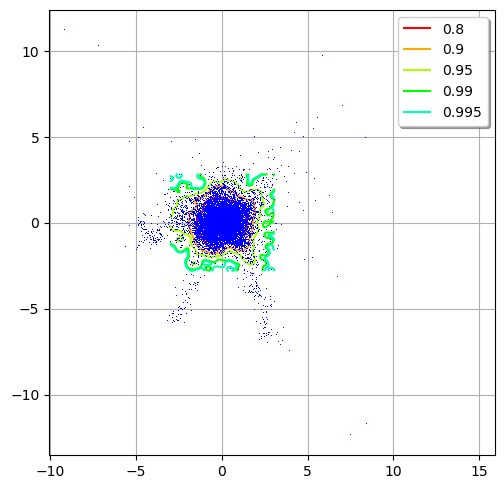

In [8]:
import openturns.viewer as otv 

#Avec 2 modes
nModes = 2
X      = Xi.getMarginal ([k for k in range (nModes)])
dist   = ot.KernelSmoothing().build(X)
R      = np.array(dist.computePDF(Xi[:,:nModes]))

Xin = {}; Xout = {};
Inside = []; Outside = []
ot.ResourceMap.SetAsUnsignedInteger("Distribution-MinimumVolumeLevelSetSamplingSize", 10000)
palette = ot.Contour.BuildDefaultPalette(8)
graph = ot.Graph("","","", True, "topright")
contour = dist.drawPDF().getDrawable(0)
for k, u in enumerate( [.8, .9, .95, .99, .995]):

    l, t = dist.computeMinimumVolumeLevelSetWithThreshold(u)
    contour.setLevels([t])
    contour.setColor(palette[k])
    contour.setLegend(str(u))
    graph.add(contour)
Xin = ot.Sample(0,nModes)
Xout = ot.Sample(0,nModes)
for i in range(Xi.getSize()):
    x = Xi[i][0:nModes]
    if l.contains(x): 
        Xin.add (x)
        Inside.append (i)
    else:
        Xout.add(x)
        Outside.append (i)

cloud = ot.Cloud(Xin)
cloud.setPointStyle('dot')
cloud.setColor('blue')
graph.add(cloud)
view = otv.View(graph, (800, 600), square_axes=True)
print (" Nb Outlier = ", len (Xout))

## <font color='blue'> Export data </font>

In [105]:
import os
nModes = 64
nChannels = 59
path_data_save = os.path.normpath(os.path.join('/Users/obando_c/Documents/Neuro/EmergencyBraking/data/post_processed/nModes'+ str(nModes)))

for event_index in range(Xi.getSize()//59):
    x = Xi[0*nChannels:0*nChannels+nChannels][:,0:nModes]
    A = np.asarray(x)
    path_out = os.path.join(path_data_save, '%s_segment_%d_event.npy' % (test_id, int(eeg_events_index[event_index])))
    np.save(path_out, A)

## <font color='blue'> Non-events </font>

In [ ]:
# DO not run
import os
path_to_data = os.path.normpath(os.path.join('/Users/obando_c/Documents/Neuro/EmergencyBraking/data/post_processed/All_noevnets'))
files = sorted([elt for elt in os.listdir(path_to_data) if elt[-4:] == '.npy'],
                   key=(lambda x: int(x.split('_')[2])))

df_eeg = pd.DataFrame([])
for num, file in enumerate(files): # create a pandas df with 
    df_interval = pd.DataFrame(data = np.load(os.path.join(path_to_data,file)))
    outliers = np.unique(np.where(np.asarray(df_interval)>2000)[0])
    if len(outliers) == 0:
        df_eeg = df_eeg.append(df_interval)
    else:
        print(num)
df_eeg.to_csv(r'df_eeg_all.csv', index = False)
print(df_eeg.shape)

165
354


In [50]:
test_id = "VPja.mat" # Not used here
df_eeg_file = 'df_eeg_all.csv' # 'df_eeg_balanced.csv'Corresponds to VPja
#Lecture
df_eeg = pd.read_csv( df_eeg_file )
n_channels = 59
split   = df_eeg.shape[1] 
nSample = df_eeg.shape[0]
#Traitement  
NPeeg = np.asarray(df_eeg)
NPeegC = NPeeg-NPeeg.mean(axis=1).reshape(-1,1) # Pour qu'ils soient comparables
mu_t    = NPeegC.mean(axis=0) # Pour avoir des processus centrés

In [ ]:
for k in range(process_sample.getSize()):
    field.setValues(NPVarcC[k:k+1,:].T - mu_t.reshape(-1,1))
    process_sample[k] = field

In [52]:
process_sample = ot.ProcessSample(time_grid, nSample, dim_ch) 
field          = ot.Field(time_grid, dim_ch)                     #le 1 correspond a la dimension du champ en sortie
for k in range(process_sample.getSize()):
    field.setValues(NPeegC[k:k+dim_ch,:].T - mu_t.reshape(-1,1))
    process_sample[k] = field
Xi  = fPCA.project(process_sample)

In [ ]:
#Avec 2 modes
nModes = 2
X      = Xi.getMarginal ([k for k in range (nModes)])
dist   = ot.KernelSmoothing().build(X)
R      = np.array(dist.computePDF(Xi[:,:nModes]))

Anomalies =[]
for i in range (nSample-1):
    if (dist.computePDF(Xi[i,:nModes]) == R.min()):
        Anomalies.append(i)
print (Anomalies)
print(len(Anomalies))

 Nb Outlier =  0


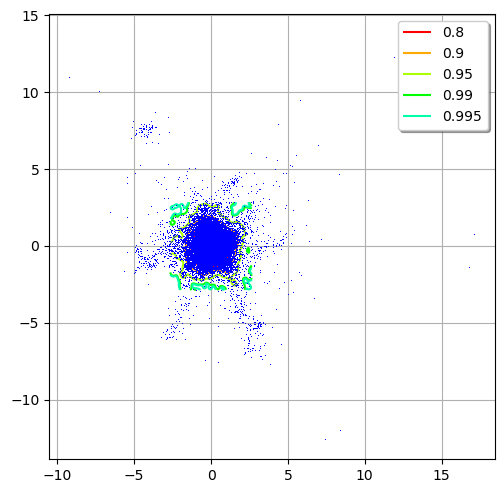

In [57]:
#Avec 2 modes
nModes = 2
X      = Xi.getMarginal ([k for k in range (nModes)])
dist   = ot.KernelSmoothing().build(X)
R      = np.array(dist.computePDF(Xi[:,:nModes]))

Xin = {}; Xout = {};
Inside = []; Outside = []
ot.ResourceMap.SetAsUnsignedInteger("Distribution-MinimumVolumeLevelSetSamplingSize", 10000)
palette = ot.Contour.BuildDefaultPalette(8)
graph = ot.Graph("","","", True, "topright")
contour = dist.drawPDF().getDrawable(0)
for k, u in enumerate( [.8, .9, .95, .99, .995]):

    l, t = dist.computeMinimumVolumeLevelSetWithThreshold(u)
    contour.setLevels([t])
    contour.setColor(palette[k])
    contour.setLegend(str(u))
    graph.add(contour)
Xin = ot.Sample(0,nModes)
Xout = ot.Sample(0,nModes)
for i in range(Xi.getSize()):
    x = Xi[i][0:nModes]
    if l.contains(x): 
        Xin.add (x)
        Inside.append (i)
    else:
        Xout.add(x)
        Outside.append (i)

cloud = ot.Cloud(Xin)
cloud.setPointStyle('dot')
cloud.setColor('blue')
graph.add(cloud)


cloud2 = ot.Cloud(Xout)
cloud2.setPointStyle('dot')
cloud2.setColor('red')
graph.add(cloud2)
view = otv.View(graph, (800, 600), square_axes=True)
print (" Nb Outlier = ", len (Xout))

In [1]:
n_channels = 59
kmeans_labels = np.empty((0,458 ))
for j in range(Xi_np.shape[1]):
    X = np.empty((0,n_channels ))
    for i in range(int(len(Xi_np)/n_channels)):
        brr = Xi_np[i*n_channels:(i+1)*n_channels,j]
        X = np.append(X, [brr], axis=0)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
    kmeans_label = np.squeeze(kmeans.labels_)
    kmeans_labels = np.append(kmeans_labels, [kmeans_label], axis=0)

NameError: name 'np' is not defined